# Predicting Voting Method in North Carolina in the 2020 General Election

<font size=3rem>
    
- **[Introduction](#Introduction)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[INTERPRET](#INTERPRET)**<br>
- **[Conclusions/Recommendations](#Conclusions/Recommendations)<br>**
</font>

# Introduction

# OBTAIN

In [1]:
## Import Numpy and set random seed for notebook
import numpy as np
np.random.seed(319)

In [2]:
## Import functions made specifically for this project
from capstone_functions import *

In [3]:
## Import remaining necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
from tzlocal import get_localzone
import plotly.express as px

In [4]:
## Set options for displaying Pandas DataFrames
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100

## 2020 Election Dataset

In [5]:
## Import and preview dataset
elec_df = pd.read_csv('Data/NC_gen_2020.zip',
                     dtype={'precinct_abbrv': str, 
                              'super_court_abbrv': str, 
                              'judic_dist_abbrv': str,
                              'school_dist_abbrv': str,
                              'vtd_abbrv': str
                             })
elec_df.drop(columns=['county_id'], inplace=True)

elec_df.head()

,ncid,no_vote_his,birth_age_adj,voting_method,Gen_2020,party_cd,gender_code,birth_year,registr_dt,race_code,ethnic_code,zip_code,res_street_address,res_city_desc,state_cd,birth_state,drivers_lic,voted_county_id,precinct_abbrv,vtd_abbrv,cong_dist_abbrv,super_court_abbrv,judic_dist_abbrv,nc_senate_abbrv,nc_house_abbrv,school_dist_abbrv
0,AA56273,0,85.0,ABSENTEE BY MAIL,Early,UNA,F,1935,1984-10-01,W,NL,27253.0,4430 E GREENSBORO-CHAPEL HILL RD,GRAHAM,NC,NY,N,1.0,08N,08N,13.0,15A,15A,24.0,64.0,NaN
1,AA201627,0,42.0,ABSENTEE ONESTOP,Early,UNA,F,1978,2018-02-23,W,UN,27302.0,117 W CLAY ST,MEBANE,NC,DC,Y,1.0,10N,10N,13.0,15A,15A,24.0,63.0,NaN
2,AA216996,0,54.0,ABSENTEE ONESTOP,Early,REP,M,1966,2020-10-31,W,UN,27302.0,3670 COVINGTON TRL,MEBANE,NC,AL,N,1.0,103,103,13.0,15A,15A,24.0,63.0,NaN
3,AA98377,0,44.0,ABSENTEE ONESTOP,Early,UNA,F,1976,1996-03-26,W,UN,27215.0,421 WHITT AVE,BURLINGTON,NC,NC,Y,1.0,03S,03S,13.0,15A,15A,24.0,64.0,NaN
4,AA69747,0,75.0,ABSENTEE ONESTOP,Early,UNA,F,1945,1989-08-15,W,NL,27215.0,1013 EDITH ST,BURLINGTON,NC,VA,Y,1.0,124,124,13.0,15A,15A,24.0,63.0,NaN


In [6]:
len(elec_df)

7347946

In [7]:
## Load in voter registration data for NC
nc_vreg = pd.read_table('Data/ncvoter_Statewide.zip', encoding='ISO-8859-1',
                        usecols=['ncid', 'county_id'])
nc_vreg.head()

,county_id,ncid
0,1,AA56273
1,1,AA201627
2,1,AA216996
3,1,AA98377
4,1,AA69747


In [8]:
## Merge county_id from voter registration info onto elec_df based on ncid
elec_df = elec_df.merge(nc_vreg, how='left', on='ncid')
# Inspect resulting df
elec_df.head()

,ncid,no_vote_his,birth_age_adj,voting_method,Gen_2020,party_cd,gender_code,birth_year,registr_dt,race_code,ethnic_code,zip_code,res_street_address,res_city_desc,state_cd,birth_state,drivers_lic,voted_county_id,precinct_abbrv,vtd_abbrv,cong_dist_abbrv,super_court_abbrv,judic_dist_abbrv,nc_senate_abbrv,nc_house_abbrv,school_dist_abbrv,county_id
0,AA56273,0,85.0,ABSENTEE BY MAIL,Early,UNA,F,1935,1984-10-01,W,NL,27253.0,4430 E GREENSBORO-CHAPEL HILL RD,GRAHAM,NC,NY,N,1.0,08N,08N,13.0,15A,15A,24.0,64.0,NaN,1
1,AA201627,0,42.0,ABSENTEE ONESTOP,Early,UNA,F,1978,2018-02-23,W,UN,27302.0,117 W CLAY ST,MEBANE,NC,DC,Y,1.0,10N,10N,13.0,15A,15A,24.0,63.0,NaN,1
2,AA216996,0,54.0,ABSENTEE ONESTOP,Early,REP,M,1966,2020-10-31,W,UN,27302.0,3670 COVINGTON TRL,MEBANE,NC,AL,N,1.0,103,103,13.0,15A,15A,24.0,63.0,NaN,1
3,AA98377,0,44.0,ABSENTEE ONESTOP,Early,UNA,F,1976,1996-03-26,W,UN,27215.0,421 WHITT AVE,BURLINGTON,NC,NC,Y,1.0,03S,03S,13.0,15A,15A,24.0,64.0,NaN,1
4,AA69747,0,75.0,ABSENTEE ONESTOP,Early,UNA,F,1945,1989-08-15,W,NL,27215.0,1013 EDITH ST,BURLINGTON,NC,VA,Y,1.0,124,124,13.0,15A,15A,24.0,63.0,NaN,1


## Merge 2016 Presidential Election Results by County

In [9]:
## Load in 2016 election results by county
results_2016 = pd.read_table('Data/results_sort_20161108.txt')
results_2016.head()

,county_id,county_desc,precinct_code,precinct_desc,contest_name,vote_for,candidate_name,votes
0,1,ALAMANCE,01,PATTERSON,ALAMANCE COUNTY BOARD OF COMMISSIONERS,3.0,Bill Lashley,1489
1,1,ALAMANCE,01,PATTERSON,ALAMANCE COUNTY BOARD OF COMMISSIONERS,3.0,Eddie Boswell,1716
2,1,ALAMANCE,01,PATTERSON,ALAMANCE COUNTY BOARD OF COMMISSIONERS,3.0,OVER VOTES,0
3,1,ALAMANCE,01,PATTERSON,ALAMANCE COUNTY BOARD OF COMMISSIONERS,3.0,Timothy (Tim) Sutton,1521
4,1,ALAMANCE,01,PATTERSON,ALAMANCE COUNTY BOARD OF COMMISSIONERS,3.0,Tom Gamble,478


In [10]:
## Get the data for the presidential race only
pres_elec_2016 = results_2016.groupby('contest_name').get_group('US PRESIDENT')
pres_elec_2016.head()

,county_id,county_desc,precinct_code,precinct_desc,contest_name,vote_for,candidate_name,votes
119,1,ALAMANCE,01,PATTERSON,US PRESIDENT,1.0,Donald J. Trump,1865
120,1,ALAMANCE,01,PATTERSON,US PRESIDENT,1.0,Gary Johnson,50
121,1,ALAMANCE,01,PATTERSON,US PRESIDENT,1.0,Hillary Clinton,411
122,1,ALAMANCE,01,PATTERSON,US PRESIDENT,1.0,OVER VOTES,0
123,1,ALAMANCE,01,PATTERSON,US PRESIDENT,1.0,UNDER VOTES,16


In [11]:
## Group the data by county and get the total votes cast per county
total_votes_by_county = pres_elec_2016.groupby(['county_id']).sum()
total_votes_by_county.drop(columns=['vote_for'], inplace=True)
total_votes_by_county.reset_index(inplace=True)
total_votes_by_county.head()

,county_id,votes
0,1,71564
1,2,18443
2,3,5387
3,4,10594
4,5,13637


In [12]:
## Group the data by county, then by candidate to get the total votes
  ## received by each candidate in each county
county_votes_by_cand = pres_elec_2016.groupby(['county_id',
                                                'candidate_name']).sum()
county_votes_by_cand.drop(columns=['vote_for'], inplace=True)
county_votes_by_cand.reset_index(inplace=True)
county_votes_by_cand.head()

,county_id,candidate_name,votes
0,1,Donald J. Trump,38815
1,1,Gary Johnson,1795
2,1,Hillary Clinton,29833
3,1,OVER VOTES,8
4,1,UNDER VOTES,399


In [13]:
## Merge the 2 county dataframes into one on county_id
county_votes = county_votes_by_cand.merge(total_votes_by_county,
                                          on='county_id',
                                          suffixes=('_cand', '_total'))

## Add a column representing the percentage of countywide votes 
  ## received by each candidate
county_votes['percent'] = county_votes['votes_cand'] / county_votes['votes_total'] *100

county_votes.head(10)

,county_id,candidate_name,votes_cand,votes_total,percent
0,1,Donald J. Trump,38815,71564,54.238164
1,1,Gary Johnson,1795,71564,2.508244
2,1,Hillary Clinton,29833,71564,41.687161
3,1,OVER VOTES,8,71564,0.011179
4,1,UNDER VOTES,399,71564,0.557543
5,1,WRITE-IN,714,71564,0.997708
6,2,Donald J. Trump,13893,18443,75.329393
7,2,Gary Johnson,437,18443,2.369463
8,2,Hillary Clinton,3767,18443,20.425094
9,2,OVER VOTES,6,18443,0.032533


In [14]:
## Extract only the rows for the candidates for the 2 major political parties
county_votes_TvC = county_votes.loc[
    county_votes['candidate_name'].isin(['Donald J. Trump', 'Hillary Clinton'])]
## Set the mutiindex by county, then by candidate
county_votes_TvC.set_index(['county_id', 'candidate_name'], inplace=True)
county_votes_TvC.head()

votes_cand  votes_total    percent
county_id candidate_name                                     
1         Donald J. Trump       38815        71564  54.238164
          Hillary Clinton       29833        71564  41.687161
2         Donald J. Trump       13893        18443  75.329393
          Hillary Clinton        3767        18443  20.425094
3         Donald J. Trump        3814         5387  70.800074

In [15]:
## Unstack the candidate index
county_per_TvC = county_votes_TvC.unstack('candidate_name')

## Keep only the columns representing the % of votes earned by Trump and 
  ## by Clinton within each county
county_per_TvC = county_per_TvC['percent'].copy()
county_per_TvC.head()

candidate_name,Donald J. Trump,Hillary Clinton
county_id,,
1,54.238164,41.687161
2,75.329393,20.425094
3,70.800074,24.243549
4,42.457995,55.370965
5,69.010779,25.665469


In [16]:
## Create a new column representing the difference in vote percentage
  ## earned by each candidate (Trump - Clinton)
county_per_TvC['diff'] = county_per_TvC['Donald J. Trump'] - county_per_TvC['Hillary Clinton']
county_per_TvC.reset_index(inplace=True)
county_per_TvC.head()

candidate_name,county_id,Donald J. Trump,Hillary Clinton,diff
0,1,54.238164,41.687161,12.551003
1,2,75.329393,20.425094,54.904300
2,3,70.800074,24.243549,46.556525
3,4,42.457995,55.370965,-12.912970
4,5,69.010779,25.665469,43.345311


Text(0, 0.5, 'Count')

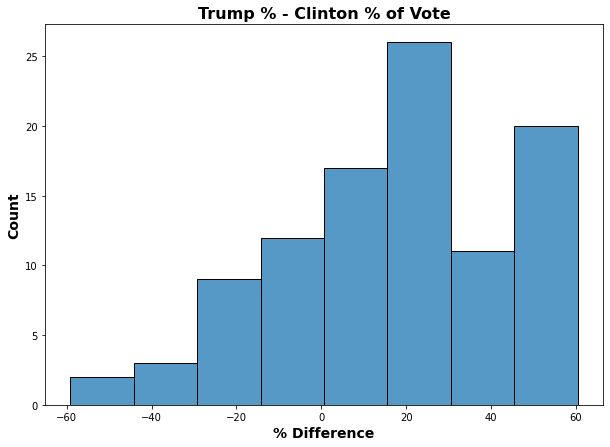

In [17]:
## Plot distribution of difference between vote earned by Trump and by Clinton
  ## in 2016 by county
plt.figure(figsize=(10,7))
ax = sns.histplot(county_per_TvC['diff'])
ax.set_title('Trump % - Clinton % of Vote', fontsize=16, weight='bold')
ax.set_xlabel('% Difference', fontsize=14, weight='bold')
ax.set_ylabel('Count', fontsize=14, weight='bold')

> Since Trump won NC in 2016, it makes sense that the majority of counties have a positive difference (meaning Trump received more of the votes in that county).

In [18]:
## Merge the diff column onto the full 2020 election df on county_id
elec_df = elec_df.merge(county_per_TvC.drop(columns=['Donald J. Trump',
                                             'Hillary Clinton']),
                        how='left', on='county_id')
elec_df.head()

,ncid,no_vote_his,birth_age_adj,voting_method,Gen_2020,party_cd,gender_code,birth_year,registr_dt,race_code,ethnic_code,zip_code,res_street_address,res_city_desc,state_cd,birth_state,drivers_lic,voted_county_id,precinct_abbrv,vtd_abbrv,cong_dist_abbrv,super_court_abbrv,judic_dist_abbrv,nc_senate_abbrv,nc_house_abbrv,school_dist_abbrv,county_id,diff
0,AA56273,0,85.0,ABSENTEE BY MAIL,Early,UNA,F,1935,1984-10-01,W,NL,27253.0,4430 E GREENSBORO-CHAPEL HILL RD,GRAHAM,NC,NY,N,1.0,08N,08N,13.0,15A,15A,24.0,64.0,NaN,1,12.551003
1,AA201627,0,42.0,ABSENTEE ONESTOP,Early,UNA,F,1978,2018-02-23,W,UN,27302.0,117 W CLAY ST,MEBANE,NC,DC,Y,1.0,10N,10N,13.0,15A,15A,24.0,63.0,NaN,1,12.551003
2,AA216996,0,54.0,ABSENTEE ONESTOP,Early,REP,M,1966,2020-10-31,W,UN,27302.0,3670 COVINGTON TRL,MEBANE,NC,AL,N,1.0,103,103,13.0,15A,15A,24.0,63.0,NaN,1,12.551003
3,AA98377,0,44.0,ABSENTEE ONESTOP,Early,UNA,F,1976,1996-03-26,W,UN,27215.0,421 WHITT AVE,BURLINGTON,NC,NC,Y,1.0,03S,03S,13.0,15A,15A,24.0,64.0,NaN,1,12.551003
4,AA69747,0,75.0,ABSENTEE ONESTOP,Early,UNA,F,1945,1989-08-15,W,NL,27215.0,1013 EDITH ST,BURLINGTON,NC,VA,Y,1.0,124,124,13.0,15A,15A,24.0,63.0,NaN,1,12.551003


In [19]:
## Create a new column that represents how the voters' party fared in their 
  ## county during the 2016 election if they aligned with one of the 2 major 
    ## parties when registering to vote
## Republicans get the unaltered diff because it was calculated as 
  ## % Trump vote - % Clinton vote, and Democrats get the opposite
elec_df['county_party_res_2016'] = np.where(elec_df['party_cd']=='REP', 
                                           elec_df['diff'], -elec_df['diff'])

## Use floor division to turn the difference into a bin that essentially 
  ## represents magnitude of difference 
    ## Adjust by 1 so that 1 represents REP win by margin of less 10% or less,
    ## 2 (or -2) represents between 10% and 20% margin, etc
elec_df['county_party_res_2016'] = (elec_df['county_party_res_2016']//10)
elec_df['county_party_res_2016'] = np.where(elec_df['county_party_res_2016']>0,
                                            elec_df['county_party_res_2016']+1,
                                            elec_df['county_party_res_2016']-1)

## If the voter chose not to align themselves with one of the 2 major parties,
  ## this will be reflected with a 0
elec_df.loc[elec_df['party_cd'].isin(['UNA',
                                      'LIB',
                                      'CST',
                                      'GRE']),
            'county_party_res_2016'] = 0

In [20]:
## Create an alternate form of the above variable that bins the difference
  ## into 1 (voter's party won county), -1 (voter's party lost county),
    ## or 0 (voter not aligned with either of the 2 major parties)
def bin_county_party_res(county_party_res):
    
    if county_party_res > 0:
        return 1
    
    elif county_party_res < 0: 
        return -1
    
    else:
        return county_party_res

In [21]:
elec_df['county_party_res_2016_tri'] = elec_df['county_party_res_2016'].apply(bin_county_party_res)

In [22]:
elec_df.head(10)

,ncid,no_vote_his,birth_age_adj,voting_method,Gen_2020,party_cd,gender_code,birth_year,registr_dt,race_code,ethnic_code,zip_code,res_street_address,res_city_desc,state_cd,birth_state,drivers_lic,voted_county_id,precinct_abbrv,vtd_abbrv,cong_dist_abbrv,super_court_abbrv,judic_dist_abbrv,nc_senate_abbrv,nc_house_abbrv,school_dist_abbrv,county_id,diff,county_party_res_2016,county_party_res_2016_tri
0,AA56273,0,85.0,ABSENTEE BY MAIL,Early,UNA,F,1935,1984-10-01,W,NL,27253.0,4430 E GREENSBORO-CHAPEL HILL RD,GRAHAM,NC,NY,N,1.0,08N,08N,13.0,15A,15A,24.0,64.0,NaN,1,12.551003,0.0,0.0
1,AA201627,0,42.0,ABSENTEE ONESTOP,Early,UNA,F,1978,2018-02-23,W,UN,27302.0,117 W CLAY ST,MEBANE,NC,DC,Y,1.0,10N,10N,13.0,15A,15A,24.0,63.0,NaN,1,12.551003,0.0,0.0
2,AA216996,0,54.0,ABSENTEE ONESTOP,Early,REP,M,1966,2020-10-31,W,UN,27302.0,3670 COVINGTON TRL,MEBANE,NC,AL,N,1.0,103,103,13.0,15A,15A,24.0,63.0,NaN,1,12.551003,2.0,1.0
3,AA98377,0,44.0,ABSENTEE ONESTOP,Early,UNA,F,1976,1996-03-26,W,UN,27215.0,421 WHITT AVE,BURLINGTON,NC,NC,Y,1.0,03S,03S,13.0,15A,15A,24.0,64.0,NaN,1,12.551003,0.0,0.0
4,AA69747,0,75.0,ABSENTEE ONESTOP,Early,UNA,F,1945,1989-08-15,W,NL,27215.0,1013 EDITH ST,BURLINGTON,NC,VA,Y,1.0,124,124,13.0,15A,15A,24.0,63.0,NaN,1,12.551003,0.0,0.0
5,AA170513,0,72.0,ABSENTEE ONESTOP,Early,DEM,M,1948,2012-03-07,W,UN,27253.0,5608 OLD CHEROKEE LN,GRAHAM,NC,MA,N,1.0,08N,08N,13.0,15A,15A,24.0,64.0,NaN,1,12.551003,-3.0,-1.0
6,BM49306,0,54.0,ABSENTEE ONESTOP,Early,DEM,F,1966,2020-06-01,B,NL,27215.0,187 CAVALIER WAY #104,BURLINGTON,NC,NC,Y,1.0,03S,03S,13.0,15A,15A,24.0,64.0,NaN,1,12.551003,-3.0,-1.0
7,AA91549,0,44.0,ABSENTEE ONESTOP,Early,UNA,M,1976,1994-10-10,W,UN,27215.0,421 WHITT AVE,BURLINGTON,NC,NC,Y,1.0,03S,03S,13.0,15A,15A,24.0,64.0,NaN,1,12.551003,0.0,0.0
8,AA125250,0,48.0,ABSENTEE BY MAIL,Early,UNA,M,1972,2013-12-05,W,UN,27215.0,1013 EDITH ST,BURLINGTON,NC,VA,Y,1.0,124,124,13.0,15A,15A,24.0,63.0,NaN,1,12.551003,0.0,0.0
9,AA181361,0,45.0,ABSENTEE BY MAIL,Early,UNA,F,1975,2013-12-05,W,HL,27215.0,1013 EDITH ST,BURLINGTON,NC,NaN,N,1.0,124,124,13.0,15A,15A,24.0,63.0,NaN,1,12.551003,0.0,0.0


# SCRUB

In [23]:
## Check df metadata
elec_df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7347946 entries, 0 to 7347945
Data columns (total 30 columns):
ncid                         7347946 non-null object
no_vote_his                  7347946 non-null int64
birth_age_adj                7347946 non-null float64
voting_method                5353091 non-null object
Gen_2020                     7347946 non-null object
party_cd                     7347946 non-null object
gender_code                  7347946 non-null object
birth_year                   7347946 non-null int64
registr_dt                   7347946 non-null object
race_code                    7347946 non-null object
ethnic_code                  7347946 non-null object
zip_code                     7347686 non-null float64
res_street_address           7347946 non-null object
res_city_desc                7347686 non-null object
state_cd                     7347686 non-null object
birth_state                  5933008 non-null object
drivers_lic                  7347946 no

> Columns with missing values:
* `voting_method`: missing values are all cases where the individual did not cast a vote in this election
* `zip_code`: missing where voter info is confidential
* `res_street_address`: has no null values, but 260 values are "CONFIDENTIAL", corresponding to the 260 null values for `zip_code`, `res_city_desc`, and `state_cd`
* `res_city_desc`: missing where voter info is confidential
* `state_cd`: missing where voter info is confidential
* `birth_state`: with so many values missing, probably want to make 'missing' its own category for this feature
* `precinct_abbrv`:
* `vtd_abbrv`:
* `cong_dist_abbrv`:
* `super_court_abbrv`:
* `judic_dist_abbrv`:
* `nc_senate_abbrv`:
* `nc_house_abbrv`:
* `school_dist_abbrv`:

> Column dtypes:
* `registr_dt`: recast as datetime
* `zip_code`: likely more useful to treat as a categorical variable rather than as numeric
* `drivers_lic`: change from Y or N to 1 or 0

In [24]:
## Fill null values in voting_method with 'No Vote'
elec_df['voting_method'].fillna(value='No Vote', inplace=True)

In [25]:
## Fill null values in birth_state with 'Missing'
elec_df['birth_state'].fillna(value='Missing', inplace=True)

In [26]:
## Change drivers_license to binary indicator
elec_df['drivers_lic_bin'] = np.where(elec_df['drivers_lic']=='Y', 1, 0)

In [27]:
## Recast zip_code as category
elec_df['zip_code'] = elec_df['zip_code'].astype('category')

In [28]:
## Recast registr_dt as datetime variable
elec_df['registr_dt'] = pd.to_datetime(elec_df['registr_dt'])

In [29]:
## Recheck elec_df metadata
elec_df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7347946 entries, 0 to 7347945
Data columns (total 30 columns):
ncid                         7347946 non-null object
no_vote_his                  7347946 non-null int64
birth_age_adj                7347946 non-null float64
voting_method                7347946 non-null object
Gen_2020                     7347946 non-null object
party_cd                     7347946 non-null object
gender_code                  7347946 non-null object
birth_year                   7347946 non-null int64
registr_dt                   7347946 non-null datetime64[ns]
race_code                    7347946 non-null object
ethnic_code                  7347946 non-null object
zip_code                     7347686 non-null category
res_street_address           7347946 non-null object
res_city_desc                7347686 non-null object
state_cd                     7347686 non-null object
birth_state                  7347946 non-null object
drivers_lic                  7

In [30]:
## Check summary statistics of numerical columns
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(elec_df.describe())

,no_vote_his,birth_age_adj,birth_year,drivers_lic,voted_county_id,cong_dist_abbrv,nc_senate_abbrv,nc_house_abbrv,county_id,diff,county_party_res_2016,county_party_res_2016_tri
count,7347946.00,7347946.00,7347946.00,7347946.00,5353091.00,7346994.00,7346994.00,7346994.00,7347946.00,7347946.00,7347946.00,7347946.00
mean,0.13,48.65,1971.35,0.87,52.37,7.02,25.78,60.73,52.90,3.49,0.27,0.08
std,0.33,18.74,18.74,0.34,27.67,3.72,14.26,34.42,27.46,29.73,3.03,0.81
min,0.00,18.00,1753.00,0.00,1.00,1.00,1.00,1.00,1.00,-59.16,-8.00,-1.00
25%,0.00,32.00,1957.00,1.00,32.00,4.00,14.00,31.00,32.00,-20.08,-2.00,-1.00
50%,0.00,48.00,1972.00,1.00,53.00,7.00,26.00,60.00,55.00,2.48,0.00,0.00
75%,0.00,63.00,1988.00,1.00,75.00,10.00,38.00,91.00,76.00,30.12,3.00,1.00
max,1.00,267.00,2002.00,1.00,100.00,13.00,50.00,120.00,100.00,60.38,7.00,1.00


> Most of these numerical variables appear to make sense. However, the oldest voter is recorded as being 267 years old. This is obviously incorrect, so this column will need to be investigated further and outliers/ obviously incorrect data fixed or dropped.

## Investigate and Drop Age Outliers

In [31]:
## A total of 1833 registered voters are over the age of 115, the age of the 
  ## oldest human alive in the US in 2020
elec_df.loc[elec_df['birth_age_adj']>115]

,ncid,no_vote_his,birth_age_adj,voting_method,Gen_2020,party_cd,gender_code,birth_year,registr_dt,race_code,ethnic_code,zip_code,res_street_address,res_city_desc,state_cd,birth_state,drivers_lic,voted_county_id,precinct_abbrv,vtd_abbrv,cong_dist_abbrv,super_court_abbrv,judic_dist_abbrv,nc_senate_abbrv,nc_house_abbrv,school_dist_abbrv,county_id,diff,county_party_res_2016,county_party_res_2016_tri
74502,AA64367,0,120.0,IN-PERSON,Election Day,REP,F,1900,1988-02-24,W,NL,27253.0,506 WILDWOOD LN,GRAHAM,NC,NC,0,1.0,064,064,13.0,15A,15A,24.0,63.0,NaN,1,12.551003,2.0,1.0
111036,AB8706,1,120.0,No Vote,No Vote,REP,F,1900,1984-10-04,W,NL,28681.0,24 S DUNCAN HILL LN,TAYLORSVILLE,NC,Missing,0,NaN,B2,B2,5.0,22A,22A,42.0,94.0,S01,2,54.904300,6.0,1.0
115409,AB2684,0,120.0,No Vote,No Vote,DEM,F,1900,1982-05-07,W,NL,28681.0,231 KEN SMITH LN,TAYLORSVILLE,NC,Missing,0,NaN,T2T3,T3,5.0,22A,22A,42.0,94.0,S02,2,54.904300,-7.0,-1.0
118201,AB8204,1,120.0,No Vote,No Vote,REP,M,1900,1986-04-01,W,NL,28678.0,240 BARNES LN,STONY POINT,NC,Missing,0,NaN,S1S2,S2,5.0,22A,22A,42.0,94.0,S04,2,54.904300,6.0,1.0
125715,AB2994,1,120.0,No Vote,No Vote,DEM,M,1900,1980-06-23,W,NL,28681.0,191 TAYLORSVILLE MFG RD,TAYLORSVILLE,NC,Missing,0,NaN,T2T3,T3,5.0,22A,22A,42.0,94.0,S02,2,54.904300,-7.0,-1.0
127257,AB6855,1,120.0,No Vote,No Vote,DEM,M,1900,1986-10-03,W,NL,28636.0,199 ERVIN LN,HIDDENITE,NC,Missing,0,NaN,S1S2,S1,5.0,22A,22A,42.0,94.0,S04,2,54.904300,-7.0,-1.0
132994,AB13864,1,120.0,No Vote,No Vote,REP,M,1900,1968-03-16,W,NL,28681.0,450 SILAS DEAL RD,TAYLORSVILLE,NC,Missing,0,NaN,LRSL,SL,5.0,22A,22A,42.0,94.0,S04,2,54.904300,6.0,1.0
157054,AD6866,1,117.0,No Vote,No Vote,DEM,F,1903,1956-08-25,B,NL,28091.0,118 EIGHTH ST,LILESVILLE,NC,NC,0,NaN,LILE,LILE,9.0,16A,16A,25.0,55.0,SCH2,4,-12.912970,2.0,1.0
200896,AG18244,0,119.0,No Vote,No Vote,DEM,M,1901,1965-10-23,B,NL,27889.0,1308 WHOOTENTOWN RD,WASHINGTON,NC,NC,0,NaN,WASHP,WASHP,3.0,02,02,3.0,79.0,SD7,7,24.022114,-4.0,-1.0
202536,AG13113,0,119.0,No Vote,No Vote,DEM,M,1901,1968-10-19,B,NL,27889.0,929 BRIDGE ST,WASHINGTON,NC,NC,0,NaN,PSJW3,PSJW3,3.0,02,02,3.0,79.0,SD1,7,24.022114,-4.0,-1.0


In [32]:
## The majority of those recorded as over 115 (1047 of the 1833) did not cast
  ## a vote in the election
    ## Presumably those that did have had their age recorded incorrectly
elec_df.loc[elec_df['birth_age_adj']>115]['Gen_2020'].value_counts()

No Vote         1047
Early            631
Election Day     152
Other              3
Name: Gen_2020, dtype: int64

In [33]:
## Most of those that are listed as over 115 years of age are recorded as 
  ## born in 1900 (120 years of age), so this may have been a placeholder
elec_df.loc[elec_df['birth_age_adj']>115]['birth_age_adj'].value_counts()

120.0    1777
119.0      23
136.0       4
117.0       4
121.0       3
118.0       3
267.0       3
116.0       2
167.0       2
123.0       2
138.0       2
255.0       1
224.0       1
248.0       1
127.0       1
135.0       1
244.0       1
150.0       1
241.0       1
Name: birth_age_adj, dtype: int64

> The 1833 registered voters over the age of 115 will be dropped from the DataFrame since this information is obviously incorrect (the oldest human alive in the United States as of 2020 is 115 years old).

In [34]:
## Drop all records with birth_age_adj greater than 115
over_115 = elec_df.loc[elec_df['birth_age_adj']>115]
elec_df.drop(index=over_115.index, inplace=True)

In [35]:
## Check summary statistics of categorical columns
elec_df.describe(include=['O'])

,ncid,voting_method,Gen_2020,party_cd,gender_code,race_code,ethnic_code,res_street_address,res_city_desc,state_cd,birth_state,precinct_abbrv,vtd_abbrv,super_court_abbrv,judic_dist_abbrv,school_dist_abbrv
count,7346113,7346113,7346113,7346113,7346113,7346113,7346113,7346113,7345854,7345854,7346113,7345164,7345164,7345164,7345164,5803942
unique,7346113,8,4,6,4,9,3,3712431,764,3,59,1892,1805,73,48,149
top,EP38964,ABSENTEE ONESTOP,Early,DEM,F,W,NL,1 DUKE UNIVERSITY WEST CAMPUS,CHARLOTTE,NC,NC,02,04,28,26,2
freq,1,3342998,4485152,2615304,3643128,4686250,5199824,3849,670281,7345836,2890302,57378,75997,207133,791501,553688


## Investigate Missing Values

In [36]:
## Check number of null values for zip_code
elec_df['zip_code'].isna().sum()

259

In [37]:
## Check the 259 records with missing zip_code
elec_df.loc[elec_df['zip_code'].isna()]

,ncid,no_vote_his,birth_age_adj,voting_method,Gen_2020,party_cd,gender_code,birth_year,registr_dt,race_code,ethnic_code,zip_code,res_street_address,res_city_desc,state_cd,birth_state,drivers_lic,voted_county_id,precinct_abbrv,vtd_abbrv,cong_dist_abbrv,super_court_abbrv,judic_dist_abbrv,nc_senate_abbrv,nc_house_abbrv,school_dist_abbrv,county_id,diff,county_party_res_2016,county_party_res_2016_tri
8254,AA50616,0,55.0,IN-PERSON,Election Day,UNA,F,1965,1984-02-15,W,NL,NaN,CONFIDENTIAL,NaN,NaN,CA,1,1.0,103,103,13.0,15A,15A,24.0,63.0,NaN,1,12.551003,0.0,0.0
36754,AP84914,0,30.0,ABSENTEE ONESTOP,Early,REP,F,1990,2020-08-10,W,NL,NaN,CONFIDENTIAL,NaN,NaN,NC,1,1.0,06E,06E,13.0,15A,15A,24.0,63.0,NaN,1,12.551003,2.0,1.0
56866,AA192589,0,30.0,No Vote,No Vote,UNA,M,1990,2016-10-10,B,NL,NaN,CONFIDENTIAL,NaN,NaN,CT,1,NaN,13,13,13.0,15A,15A,24.0,63.0,NaN,1,12.551003,0.0,0.0
95641,DE225925,0,33.0,ABSENTEE ONESTOP,Early,DEM,F,1987,2019-10-03,W,NL,NaN,CONFIDENTIAL,NaN,NaN,NC,1,1.0,11,11,13.0,15A,15A,24.0,63.0,NaN,1,12.551003,-3.0,-1.0
139484,AC14362,0,71.0,No Vote,No Vote,UNA,M,1949,2010-09-09,W,UN,NaN,CONFIDENTIAL,NaN,NaN,NJ,1,NaN,06A,06,5.0,23,23,45.0,90.0,NaN,3,46.556525,0.0,0.0
142348,AC14704,0,80.0,No Vote,No Vote,UNA,M,1940,2012-03-16,U,UN,NaN,CONFIDENTIAL,NaN,NaN,Missing,1,NaN,03A,07,5.0,23,23,45.0,90.0,NaN,3,46.556525,0.0,0.0
285329,AK171004,0,51.0,ABSENTEE ONESTOP,Early,DEM,F,1969,2020-10-09,W,NL,NaN,CONFIDENTIAL,NaN,NaN,NC,1,10.0,14,14,7.0,13B,13,8.0,17.0,2,10,28.280448,-4.0,-1.0
286643,DB221759,0,60.0,No Vote,No Vote,DEM,F,1960,2012-10-25,W,NL,NaN,CONFIDENTIAL,NaN,NaN,OC,1,NaN,02,02,7.0,13B,13,8.0,17.0,5,10,28.280448,-4.0,-1.0
317343,DB277475,0,29.0,ABSENTEE ONESTOP,Early,DEM,F,1991,2020-02-07,W,NL,NaN,CONFIDENTIAL,NaN,NaN,PA,0,10.0,03,03,7.0,13B,13,8.0,17.0,5,10,28.280448,-4.0,-1.0
332450,DT108296,0,58.0,ABSENTEE BY MAIL,Early,REP,F,1962,2020-08-17,W,UN,NaN,CONFIDENTIAL,NaN,NaN,FL,1,10.0,14,14,7.0,13B,13,8.0,17.0,2,10,28.280448,3.0,1.0


> The records missing `zip_code` also correspond to the records missing `res_city_desc` and `state_cd`, most likely because the residential address is confidential for these individuals. There are so many cities (765) and zipcodes (843) represented in this dataset that these two variables may not be all that useful as predictors and may lead to overfitting. These seems especially likely given that some cities/ zip codes only appear for a handful of records. The county in which the voter is registered may serve as a better predictor representing geographic location since there are only 100 counties. This variable is also not missing any values.

In [38]:
## Check number of null values for precinct_abbrv
elec_df['precinct_abbrv'].isna().sum()

949

In [39]:
## Check the 949 records with missing precinct_abbrv
missing_precinct_info = elec_df.loc[elec_df['precinct_abbrv'].isna()]
missing_precinct_info

,ncid,no_vote_his,birth_age_adj,voting_method,Gen_2020,party_cd,gender_code,birth_year,registr_dt,race_code,ethnic_code,zip_code,res_street_address,res_city_desc,state_cd,birth_state,drivers_lic,voted_county_id,precinct_abbrv,vtd_abbrv,cong_dist_abbrv,super_court_abbrv,judic_dist_abbrv,nc_senate_abbrv,nc_house_abbrv,school_dist_abbrv,county_id,diff,county_party_res_2016,county_party_res_2016_tri
34725,DE278765,0,58.0,No Vote,No Vote,DEM,U,1962,2016-09-23,U,UN,27302.0,1026 MEBANE OAKS RD,MEBANE,NC,Missing,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,12.551003,-3.0,-1.0
180385,AF25244,0,32.0,No Vote,No Vote,UNA,F,1988,2012-10-12,U,UN,28604.0,5200 NC HWY 105 S,BANNER ELK,NC,Missing,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,55.336775,0.0,0.0
187558,AF25346,1,35.0,No Vote,No Vote,UNA,U,1985,2012-11-06,U,UN,28604.0,9189 NC HWY 105 S,BANNER ELK,NC,Missing,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,55.336775,0.0,0.0
190788,AF6115,0,44.0,PROVISIONAL,Other,REP,F,1976,1994-12-14,W,NL,28646.0,0 COFFEY RD,LINVILLE,NC,CA,0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,55.336775,6.0,1.0
228017,AH4335,1,58.0,No Vote,No Vote,DEM,F,1962,1984-09-29,B,NL,27924.0,0 UNKNOWN,COLERAIN,NC,NC,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,-24.683072,3.0,1.0
228880,AH5323,1,48.0,No Vote,No Vote,DEM,M,1972,1990-04-06,B,NL,27983.0,201 TIMS ST,WINDSOR,NC,NC,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,-24.683072,3.0,1.0
231359,AH7861,1,102.0,No Vote,No Vote,DEM,F,1918,1954-05-15,W,NL,27805.0,0 UNKNOWN,AULANDER,NC,NC,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,-24.683072,3.0,1.0
231905,AH8499,1,51.0,No Vote,No Vote,DEM,F,1969,1988-03-22,W,NL,27805.0,0 UNKNOWN,AULANDER,NC,NC,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,-24.683072,3.0,1.0
231992,AH8605,1,46.0,No Vote,No Vote,REP,F,1974,1993-10-11,W,NL,27805.0,0 UNKNOWN,AULANDER,NC,NC,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,-24.683072,-4.0,-1.0
232153,AH8781,1,42.0,No Vote,No Vote,DEM,F,1978,1998-03-25,B,NL,27847.0,0 CHURCH ST,KELFORD,NC,VA,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,-24.683072,3.0,1.0


In [40]:
## Check what other district info is missing for records missing precinct
pct_dist_info = ['precinct_abbrv', 'vtd_abbrv', 'cong_dist_abbrv',
                 'super_court_abbrv', 'judic_dist_abbrv', 'nc_senate_abbrv',
                 'nc_house_abbrv', 'school_dist_abbrv']

for col in pct_dist_info:
    print('***** {} *****'.format(col))
    print('Total null values in column: {}'.format(missing_precinct_info[col].isna().sum()))
    print('---'*5)
    print()

# Every record with a null value for precinct is also missing all other
  # district info

***** precinct_abbrv *****
Total null values in column: 949
---------------

***** vtd_abbrv *****
Total null values in column: 949
---------------

***** cong_dist_abbrv *****
Total null values in column: 949
---------------

***** super_court_abbrv *****
Total null values in column: 949
---------------

***** judic_dist_abbrv *****
Total null values in column: 949
---------------

***** nc_senate_abbrv *****
Total null values in column: 949
---------------

***** nc_house_abbrv *****
Total null values in column: 949
---------------

***** school_dist_abbrv *****
Total null values in column: 949
---------------



In [41]:
check_unique('voting_method', missing_precinct_info)

,count,%
No Vote,932,98.21
PROVISIONAL,8,0.84
ABSENTEE ONESTOP,5,0.53
ABSENTEE BY MAIL,2,0.21
IN-PERSON,1,0.11
CURBSIDE,1,0.11


In [42]:
check_unique('no_vote_his', missing_precinct_info)

,count,%
1,539,56.8
0,410,43.2


In [43]:
check_unique('county_id', missing_precinct_info)

,count,%
60,192,20.23
50,185,19.49
11,184,19.39
26,62,6.53
78,43,4.53
74,40,4.21
32,35,3.69
71,34,3.58
68,31,3.27
8,16,1.69


In [44]:
## All records missing the voted_county_id are individuals who did not 
  ## cast a vote in this election
elec_df.loc[elec_df['voted_county_id'].isna()]['Gen_2020'].value_counts()

No Vote    1993808
Name: Gen_2020, dtype: int64

In [45]:
elec_df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7346113 entries, 0 to 7347945
Data columns (total 30 columns):
ncid                         7346113 non-null object
no_vote_his                  7346113 non-null int64
birth_age_adj                7346113 non-null float64
voting_method                7346113 non-null object
Gen_2020                     7346113 non-null object
party_cd                     7346113 non-null object
gender_code                  7346113 non-null object
birth_year                   7346113 non-null int64
registr_dt                   7346113 non-null datetime64[ns]
race_code                    7346113 non-null object
ethnic_code                  7346113 non-null object
zip_code                     7345854 non-null category
res_street_address           7346113 non-null object
res_city_desc                7345854 non-null object
state_cd                     7345854 non-null object
birth_state                  7346113 non-null object
drivers_lic                  7

> As shown above, the only columns currently missing information are those related to location. The county in which a person registered to vote (`county_id`) will be used as a predictor for modeling. The other location info can be used for visualizing trends, but they won't be used for modeling purposes due to missing info, as well as high cardinality and prevalence of many rare labels (see section below).

# EXPLORE

## Categorical Variables

In [46]:
check_unique('voting_method', elec_df)

,count,%
ABSENTEE ONESTOP,3342998,45.51
No Vote,1993808,27.14
ABSENTEE BY MAIL,983274,13.38
IN-PERSON,829922,11.30
ABSENTEE CURBSIDE,158880,2.16
PROVISIONAL,14557,0.20
CURBSIDE,13799,0.19
TRANSFER,8875,0.12


In [47]:
check_unique('Gen_2020', elec_df)

,count,%
Early,4485152,61.05
No Vote,1993808,27.14
Election Day,843721,11.49
Other,23432,0.32


> The 'Other' category is made up of only 23,432 individuals (<0.5%) that voted with either a provisional or transfer ballot. Need to consider dropping this extremely rare category or somehow adding those records into one of the other categories for purposes of modeling.

In [48]:
check_unique('party_cd', elec_df)

,count,%
DEM,2615304,35.60
UNA,2445413,33.29
REP,2230466,30.36
LIB,46489,0.63
CST,4738,0.06
GRE,3703,0.05


> LIB, CST, and GRE extremely rare within the state. Need to deal with this in some way, but grouping into a single 'Rare' category won't necessarily solve the issue since that would still represent barely more than 0.5% of voters in this election. It could make sense to combine these three parties with UNA (unaffiliated) to simply represent voters that do not align with one of the two major parties.

In [49]:
check_unique('gender_code', elec_df)

,count,%
F,3643128,49.59
M,3096471,42.15
U,606508,8.26
,6,0.00


In [50]:
## Inspect records where gender_code is encoded as whitespace
elec_df.loc[elec_df['gender_code']==' ']

,ncid,no_vote_his,birth_age_adj,voting_method,Gen_2020,party_cd,gender_code,birth_year,registr_dt,race_code,ethnic_code,zip_code,res_street_address,res_city_desc,state_cd,birth_state,drivers_lic,voted_county_id,precinct_abbrv,vtd_abbrv,cong_dist_abbrv,super_court_abbrv,judic_dist_abbrv,nc_senate_abbrv,nc_house_abbrv,school_dist_abbrv,county_id,diff,county_party_res_2016,county_party_res_2016_tri
143538,AD16896,0,55.0,ABSENTEE ONESTOP,Early,UNA,,1965,1997-08-15,W,NL,28170.0,247 HIGHLAND DR,WADESBORO,NC,NC,1,4.0,WADES,W3,9.0,16A,16A,25.0,55.0,SCH5,4,-12.912970,0.0,0.0
146513,CW730457,0,41.0,ABSENTEE ONESTOP,Early,DEM,,1979,2020-02-04,W,UN,28170.0,211 S RUTHERFORD ST,WADESBORO,NC,Missing,1,4.0,WADES,W2,9.0,16A,16A,25.0,55.0,SCH6,4,-12.912970,2.0,1.0
151670,AD31495,0,33.0,ABSENTEE ONESTOP,Early,DEM,,1987,2008-11-04,B,UN,28119.0,7355 NC 145,MORVEN,NC,Missing,1,4.0,MM,MM,9.0,16A,16A,25.0,55.0,SCH3,4,-12.912970,2.0,1.0
1209536,BC35157,0,62.0,No Vote,No Vote,REP,,1958,1996-05-30,B,NL,28431.0,5264 ANDREW JACKSON HWY SW,CHADBOURN,NC,NC,1,NaN,P06,P06,7.0,13A,13,13.0,46.0,CO,24,21.867260,3.0,1.0
2342599,BP59036,0,28.0,ABSENTEE ONESTOP,Early,REP,,1992,2020-10-08,U,UN,27525.0,50 CATLETT LN,FRANKLINTON,NC,Missing,1,35.0,14,14,4.0,09,09,18.0,7.0,SBO5,35,11.429506,2.0,1.0
7345546,ES24715,0,82.0,ABSENTEE ONESTOP,Early,REP,,1938,2020-10-30,U,UN,28714.0,1156 GEORGES FORK RD,BURNSVILLE,NC,NC,0,100.0,01 BUR,01-BUR,11.0,24,24,47.0,118.0,NaN,100,31.323053,4.0,1.0


In [51]:
## For the 6 individuals whose gender is encoded as whitespace, replace with
  ## 'U' for undesignated
elec_df.loc[elec_df['gender_code']==' ', 'gender_code']='U'
check_unique('gender_code', elec_df)

,count,%
F,3643128,49.59
M,3096471,42.15
U,606514,8.26


In [52]:
check_unique('race_code', elec_df)

,count,%
W,4686250,63.79
B,1511748,20.58
U,742414,10.11
O,198460,2.70
A,104311,1.42
I,55642,0.76
M,46897,0.64
P,389,0.01
,2,0.00


In [53]:
## Inspect records where race_code is encoded as whitespace
elec_df.loc[elec_df['race_code']==' ']

,ncid,no_vote_his,birth_age_adj,voting_method,Gen_2020,party_cd,gender_code,birth_year,registr_dt,race_code,ethnic_code,zip_code,res_street_address,res_city_desc,state_cd,birth_state,drivers_lic,voted_county_id,precinct_abbrv,vtd_abbrv,cong_dist_abbrv,super_court_abbrv,judic_dist_abbrv,nc_senate_abbrv,nc_house_abbrv,school_dist_abbrv,county_id,diff,county_party_res_2016,county_party_res_2016_tri
3250136,CE7034,0,56.0,ABSENTEE ONESTOP,Early,UNA,M,1964,1986-04-23,,NL,28376.0,136 LEBEAU DR,RAEFORD,NC,NC,1,47.0,06B,06,9.0,19D,19D,21.0,48.0,NaN,47,-10.739648,0.0,0.0
5275378,DG12086,0,54.0,ABSENTEE ONESTOP,Early,REP,F,1966,2006-11-07,,UN,27944.0,140 PATRICK DR,HERTFORD,NC,NC,1,72.0,NEW HO,NEW-HO,3.0,01,01,1.0,1.0,NaN,72,27.579041,3.0,1.0


In [54]:
## For the 2 individuals whose race is encoded as whitespace, replace with
  ## 'U' for undesignated
elec_df.loc[elec_df['race_code']==' ', 'race_code']='U'
check_unique('race_code', elec_df)

,count,%
W,4686250,63.79
B,1511748,20.58
U,742416,10.11
O,198460,2.70
A,104311,1.42
I,55642,0.76
M,46897,0.64
P,389,0.01


> The most infrequent categories (Other, Asian, Native American, Multiple, Pacific Islander/Native Hawaiian) each represent less than 5% of voters. To deal with these rare labels, it is probably best from a modeling standpoint to group them all under 'Other'.

In [55]:
check_unique('ethnic_code', elec_df)

,count,%
NL,5199824,70.78
UN,1919015,26.12
HL,227274,3.09


> Voters that chose to identify themselves as Hispanic or Latino represent less than 5% of voters. Check below to see how disclosed racial and ethnic identities intersect.

In [56]:
## Investigate how race intersects with ethnic code
for code in elec_df['ethnic_code'].unique():
    print('*****{}*****'.format(code))
    display(elec_df.loc[elec_df['ethnic_code']==code]['race_code'].value_counts().to_frame())
    print()

*****NL*****


,race_code
W,3834402
B,1121721
O,82871
A,69917
I,46207
U,22708
M,21803
P,195



*****UN*****


,race_code
W,797565
U,657553
B,382302
A,33485
O,25885
M,13531
I,8539
P,155



*****HL*****


,race_code
O,89704
U,62155
W,54283
M,11563
B,7725
A,909
I,896
P,39


> Patterns of intersection between race and ethnicity are somewhat unclear. The majority of voters that chose not to disclose their race (U) also chose not to disclose their ethnicity (UN) (657,553 out of 742,416). The majority of voters that identified themselves as Hispanic or Latino when registering listed their race as 'Other'(89,704 out of 227,274) or 'Undesignated' (62,155 out of 227,274), then 'White' (54,283 out of 227,274). As such, I am uncertain how useful this feature will be as a predictor, especially given that the 'HL' category is so rare.

In [57]:
check_unique('zip_code', elec_df)

,count,%
28269.0,57914,0.79
27587.0,56290,0.77
28277.0,54539,0.74
28078.0,49949,0.68
27610.0,49660,0.68
28027.0,49364,0.67
28173.0,47648,0.65
27410.0,43658,0.59
27406.0,43486,0.59
27713.0,43356,0.59


> There are 843 different zip codes and many of them are only represented by a few records.

In [58]:
check_unique('res_city_desc', elec_df)

,count,%
CHARLOTTE,670281,9.12
RALEIGH,402033,5.47
GREENSBORO,240144,3.27
DURHAM,229940,3.13
WINSTON SALEM,176871,2.41
FAYETTEVILLE,172437,2.35
WILMINGTON,161867,2.20
CARY,116684,1.59
ASHEVILLE,108396,1.48
CONCORD,87560,1.19


> There are 765 different cities represented for the whole state.

In [59]:
elec_df['county_id'].nunique()

100

In [60]:
check_unique('county_id', elec_df)

,count,%
92,792569,10.79
60,791693,10.78
41,383763,5.22
34,271877,3.70
32,243683,3.32
26,226219,3.08
11,207317,2.82
65,177364,2.41
90,168282,2.29
36,151774,2.07


In [61]:
check_unique('state_cd', elec_df)

,count,%
NC,7345836,100.0
NaN,259,0.0
GA,12,0.0
VA,6,0.0


In [62]:
## Inspect the 18 records (12 from GA, 6 from VA) where the voter's
  ## residential state_cd is outside NC
elec_df.loc[elec_df['state_cd'].isin(['GA', 'VA'])]

,ncid,no_vote_his,birth_age_adj,voting_method,Gen_2020,party_cd,gender_code,birth_year,registr_dt,race_code,ethnic_code,zip_code,res_street_address,res_city_desc,state_cd,birth_state,drivers_lic,voted_county_id,precinct_abbrv,vtd_abbrv,cong_dist_abbrv,super_court_abbrv,judic_dist_abbrv,nc_senate_abbrv,nc_house_abbrv,school_dist_abbrv,county_id,diff,county_party_res_2016,county_party_res_2016_tri
1124594,BA15985,0,68.0,ABSENTEE ONESTOP,Early,DEM,F,1952,2012-09-24,W,NL,30546.0,391 KOLBY LN,HIAWASSEE,GA,GA,1,22.0,HIAW,HIAW,11.0,30A,30,50.0,120.0,NaN,22,50.609957,-7.0,-1.0
1124595,BA19020,0,38.0,ABSENTEE ONESTOP,Early,DEM,F,1982,2019-06-18,W,NL,30546.0,391 KOLBY LN,HIAWASSEE,GA,CO,1,22.0,HIAW,HIAW,11.0,30A,30,50.0,120.0,NaN,22,50.609957,-7.0,-1.0
1126277,BA5483,0,62.0,No Vote,No Vote,REP,M,1958,1990-10-08,W,NL,30546.0,3035 ELLINGTON RD,HIAWASSEE,GA,OH,0,NaN,HIAW,HIAW,11.0,30A,30,50.0,120.0,NaN,22,50.609957,6.0,1.0
1126961,BA19429,0,19.0,IN-PERSON,Election Day,REP,M,2001,2020-02-05,W,UN,30546.0,693 UPPER BELL CREEK RD,HIAWASSEE,GA,GA,1,22.0,HIAW,HIAW,11.0,30A,30,50.0,120.0,NaN,22,50.609957,6.0,1.0
1126975,BA6026,0,75.0,No Vote,No Vote,REP,M,1945,1986-08-25,W,NL,30546.0,927 UPPER BELL CREEK RD,HIAWASSEE,GA,GA,0,NaN,HIAW,HIAW,11.0,30A,30,50.0,120.0,NaN,22,50.609957,6.0,1.0
1126996,BA6053,0,47.0,ABSENTEE ONESTOP,Early,REP,M,1973,1992-03-27,W,NL,30546.0,693 UPPER BELL CREEK RD,HIAWASSEE,GA,GA,1,22.0,HIAW,HIAW,11.0,30A,30,50.0,120.0,NaN,22,50.609957,6.0,1.0
1126997,BA3428,0,47.0,ABSENTEE ONESTOP,Early,REP,F,1973,1992-04-03,W,NL,30546.0,693 UPPER BELL CREEK RD,HIAWASSEE,GA,GA,0,22.0,HIAW,HIAW,11.0,30A,30,50.0,120.0,NaN,22,50.609957,6.0,1.0
1127006,BA19892,0,22.0,ABSENTEE ONESTOP,Early,DEM,U,1998,2020-10-09,U,UN,30546.0,693 UPPER BELL CREEK RD,HIAWASSEE,GA,Missing,1,22.0,HIAW,HIAW,11.0,30A,30,50.0,120.0,NaN,22,50.609957,-7.0,-1.0
1127650,BA6548,0,51.0,IN-PERSON,Election Day,REP,M,1969,2014-06-09,W,UN,30546.0,207 UPPER BELL CREEK RD,HIAWASSEE,GA,GA,1,22.0,HIAW,HIAW,11.0,30A,30,50.0,120.0,NaN,22,50.609957,6.0,1.0
1127657,BA14352,0,47.0,IN-PERSON,Election Day,UNA,F,1973,2008-10-29,W,NL,30546.0,207 UPPER BELL CREEK RD,HIAWASSEE,GA,Missing,1,22.0,HIAW,HIAW,11.0,30A,30,50.0,120.0,NaN,22,50.609957,0.0,0.0


> The 18 records above represent individuals that live in either GA or VA, very close to the NC border. The `county_id` under which their voter registrations are listed are the nearest NC county to the `res_city_desc` provided as part of their residential address. How are several of these voters casting votes in NC?? They likely ought to be removed from analysis.

In [63]:
## Drop voters whose registration lists them as living in GA or VA
elec_df.drop(index=elec_df.loc[elec_df['state_cd'].isin(['GA', 'VA'])].index, inplace=True)
check_unique('state_cd', elec_df)

,count,%
NC,7345836,100.0
NaN,259,0.0


In [64]:
elec_df['birth_state'].nunique()

59

In [65]:
check_unique('birth_state', elec_df)

,count,%
NC,2890300,39.34
Missing,1414574,19.26
NY,398069,5.42
OC,255573,3.48
VA,227534,3.10
PA,171280,2.33
SC,155498,2.12
FL,154060,2.10
NJ,149055,2.03
OH,141591,1.93


> The majority of `birth_state` labels are rare categories (less than 5% of voters). Some of the codes do not appear to be U.S. states or territories. These rare labels could be dealt with in a couple ways. They could all be grouped into an 'Other' category, or they could be grouped according to geographic region of the U.S. with an additional category for naturalized U.S. citizens.

In [66]:
elec_df.loc[elec_df['birth_state']=='OC']

,ncid,no_vote_his,birth_age_adj,voting_method,Gen_2020,party_cd,gender_code,birth_year,registr_dt,race_code,ethnic_code,zip_code,res_street_address,res_city_desc,state_cd,birth_state,drivers_lic,voted_county_id,precinct_abbrv,vtd_abbrv,cong_dist_abbrv,super_court_abbrv,judic_dist_abbrv,nc_senate_abbrv,nc_house_abbrv,school_dist_abbrv,county_id,diff,county_party_res_2016,county_party_res_2016_tri
18,DE236758,1,31.0,No Vote,No Vote,UNA,M,1989,2014-07-03,O,NL,27302.0,105 N SIXTH ST,MEBANE,NC,OC,1,NaN,10N,10N,13.0,15A,15A,24.0,63.0,NaN,1,12.551003,0.0,0.0
53,AA196723,0,26.0,ABSENTEE ONESTOP,Early,UNA,M,1994,2017-08-21,W,NL,27215.0,3031 WINSTON DR #204,BURLINGTON,NC,OC,1,1.0,129,129,13.0,15A,15A,24.0,63.0,NaN,1,12.551003,0.0,0.0
57,AA148060,0,53.0,ABSENTEE ONESTOP,Early,DEM,M,1967,2006-10-25,O,NL,27215.0,2954 ETHAN POINTE DR #4203,BURLINGTON,NC,OC,1,1.0,03S,03S,13.0,15A,15A,24.0,64.0,NaN,1,12.551003,-3.0,-1.0
60,DL221658,0,30.0,ABSENTEE ONESTOP,Early,DEM,M,1990,2020-03-12,O,UN,27302.0,1335 MEBANE OAKS RD,MEBANE,NC,OC,1,1.0,10S1,10S,13.0,15A,15A,24.0,63.0,NaN,1,12.551003,-3.0,-1.0
61,AA202162,0,29.0,ABSENTEE ONESTOP,Early,DEM,F,1991,2018-11-06,O,UN,27302.0,2000 QUAKER CREEK DR #2101,MEBANE,NC,OC,1,1.0,10S1,10S,13.0,15A,15A,24.0,63.0,NaN,1,12.551003,-3.0,-1.0
103,AA207681,0,19.0,ABSENTEE ONESTOP,Early,UNA,F,2001,2019-12-04,A,NL,27215.0,2038 WESTOVER TER,BURLINGTON,NC,OC,1,1.0,126,126,13.0,15A,15A,24.0,63.0,NaN,1,12.551003,0.0,0.0
138,AA201921,0,48.0,No Vote,No Vote,UNA,F,1972,2018-11-01,A,NL,27253.0,115 FLORENCE ST #3,GRAHAM,NC,OC,1,NaN,064,064,13.0,15A,15A,24.0,63.0,NaN,1,12.551003,0.0,0.0
142,AA206220,1,19.0,No Vote,No Vote,UNA,F,2001,2018-06-18,M,UN,27349.0,6259 BASS MOUNTAIN RD,SNOW CAMP,NC,OC,0,NaN,08N,08N,13.0,15A,15A,24.0,64.0,NaN,1,12.551003,0.0,0.0
150,AA196880,0,59.0,ABSENTEE BY MAIL,Early,UNA,M,1961,2017-09-05,A,NL,27244.0,1398 STONE GABLES DR,ELON,NC,OC,1,1.0,035,035,13.0,15A,15A,24.0,64.0,NaN,1,12.551003,0.0,0.0
151,AA187630,0,32.0,ABSENTEE BY MAIL,Early,UNA,M,1988,2016-02-12,A,NL,27244.0,1398 STONE GABLES DR,ELON,NC,OC,1,1.0,035,035,13.0,15A,15A,24.0,64.0,NaN,1,12.551003,0.0,0.0


In [67]:
elec_df.loc[elec_df['birth_state']=='NO'] # Hunter Scott Holshouser
# It seems like this may have somehow been a typo and he was likely born in 
# NC, but I can't confirm this, so probably change to "missing"

,ncid,no_vote_his,birth_age_adj,voting_method,Gen_2020,party_cd,gender_code,birth_year,registr_dt,race_code,ethnic_code,zip_code,res_street_address,res_city_desc,state_cd,birth_state,drivers_lic,voted_county_id,precinct_abbrv,vtd_abbrv,cong_dist_abbrv,super_court_abbrv,judic_dist_abbrv,nc_senate_abbrv,nc_house_abbrv,school_dist_abbrv,county_id,diff,county_party_res_2016,county_party_res_2016_tri
6145219,EF171044,0,26.0,ABSENTEE ONESTOP,Early,REP,M,1994,2010-05-18,W,NL,28079.0,517 W BRIEF RD,INDIAN TRAIL,NC,NO,1,90.0,032,032,9.0,20B,20C,36.0,69.0,4,90,30.430368,4.0,1.0


In [68]:
check_unique('drivers_lic', elec_df)

,count,%
1,6391102,87.0
0,954993,13.0


In [69]:
check_unique('precinct_abbrv', elec_df)

,count,%
02,57378,0.78
04,53865,0.73
15,44120,0.60
11,44050,0.60
05,43689,0.59
03,41060,0.56
14,40952,0.56
13,40080,0.55
07,39602,0.54
12,38910,0.53


In [70]:
check_unique('vtd_abbrv', elec_df)

,count,%
04,75997,1.03
02,57854,0.79
05,54358,0.74
03,50104,0.68
06,47686,0.65
11,47467,0.65
15,44948,0.61
13,43976,0.60
07,43863,0.60
14,43802,0.60


In [71]:
check_unique('cong_dist_abbrv', elec_df)

,count,%
4.0,645710,8.79
2.0,636299,8.66
12.0,628906,8.56
7.0,605687,8.25
11.0,591043,8.05
6.0,572019,7.79
9.0,557592,7.59
8.0,541537,7.37
10.0,535491,7.29
3.0,515211,7.01


In [72]:
check_unique('nc_senate_abbrv', elec_df)

,count,%
17.0,200283,2.73
8.0,183937,2.50
9.0,174369,2.37
41.0,174067,2.37
20.0,173019,2.36
49.0,169714,2.31
23.0,169416,2.31
38.0,168400,2.29
18.0,167343,2.28
27.0,164569,2.24


In [73]:
check_unique('nc_house_abbrv', elec_df)

,count,%
37.0,87063,1.19
41.0,81667,1.11
26.0,81646,1.11
98.0,80489,1.10
17.0,80023,1.09
19.0,79382,1.08
35.0,77886,1.06
31.0,76985,1.05
54.0,76648,1.04
29.0,76376,1.04


In [74]:
check_unique('school_dist_abbrv', elec_df)

,count,%
NaN,1542159,20.99
2,553688,7.54
1,539711,7.35
5,367649,5.00
3,347042,4.72
4,307532,4.19
6,306121,4.17
GC,151774,2.07
CAB,134401,1.83
8,134132,1.83


## Group Rare Categories

In [75]:
## Create new column that is a binary variable indicating whether the voter
  ## cast a vote in the 2020 election or not
elec_df['Gen_2020_binary'] = np.where(elec_df['Gen_2020']=='No Vote',
                                0, 1)

## Check distribution
check_unique('Gen_2020_binary', elec_df)

,count,%
1,5352294,72.86
0,1993801,27.14


In [76]:
## Create new column grouping most infrequent party categories (<5% of voters)
  ## into same group as those who are unaffiliated
elec_df['party_grp'] = np.where(elec_df['party_cd'].isin(['REP', 'DEM']),
                                elec_df['party_cd'].str.title(), 'Other')

## Check distribution
check_unique('party_grp', elec_df)

,count,%
DEM,2615300,35.60
Other,2500339,34.04
REP,2230456,30.36


In [77]:
## Create new column grouping most infrequent race categories (<5% of voters)
elec_df['race_grp'] = np.where(elec_df['race_code'].isin(['W', 'B', 'U']),
                               elec_df['race_code'], 'O')
race_grp_map = {'W': 'White',
                'B': 'Black',
                'U': 'Undesig.',
                'O': 'Other'}
elec_df['race_grp'] = elec_df['race_grp'].map(race_grp_map)

## Check distribution
check_unique('race_grp', elec_df)

,count,%
W,4686233,63.79
B,1511748,20.58
U,742415,10.11
O,405699,5.52


In [80]:
## Create a function for grouping birth_state into U.S. Census regions, 
  ## this time lumping territories and out of country into 'Other'
def get_birth_reg_census_other(state):
    
    if state in ['AS', 'GU', 'MP', 'PR', 'VI', 'OC']:
        return 'Other'
    
    # the rest of the categories are based on U.S. Census Bureau regions
    elif state in ['CT', 'ME', 'MA', 'NH', 'RI', 'VT',
                     'NJ', 'NY', 'PA']:
        return 'Northeast'
    
    elif state in ['DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 
                     'DC', 'WV', 'AL', 'KY', 'MS', 'TN', 'AR',
                     'LA', 'OK', 'TX']:
        return 'South'
    
    elif state in ['IL', 'IN', 'MI', 'OH', 'WI',
                     'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD']:
        return 'Midwest'
    
    elif state in ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT',
                     'WY', 'AK', 'CA', 'HI', 'OR', 'WA']:
        return 'West'
    
    else:
        return 'Missing'

In [81]:
## Create a new column grouping birth_state into U.S. Census regions,
  ## this time lumping territories and out of country into 'Other'
elec_df['birth_reg_other'] = elec_df['birth_state'].apply(get_birth_reg_census_other)
check_unique('birth_reg_other', elec_df)

,count,%
South,4016115,54.67
Missing,1414575,19.26
Northeast,886440,12.07
Midwest,507904,6.91
Other,278043,3.78
West,243018,3.31


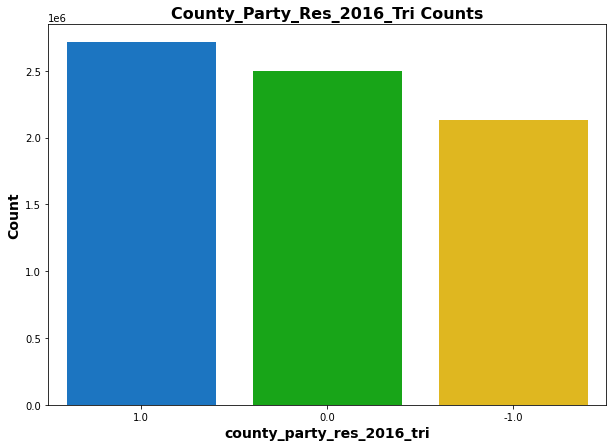

In [82]:
plot_count('county_party_res_2016_tri', elec_df);

In [83]:
check_unique('county_party_res_2016_tri', elec_df)

,count,%
1.0,2711791,36.91
0.0,2500339,34.04
-1.0,2133965,29.05


## Numeric Variables

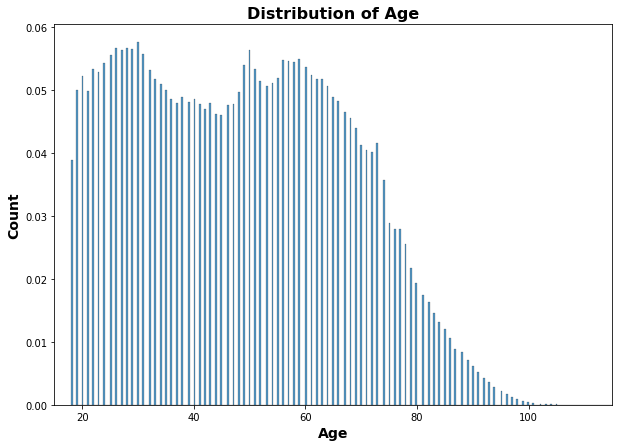

In [84]:
## Plot distribution of current age as of EOY 2020 
plt.figure(figsize=(10,7))
ax = sns.histplot(elec_df['birth_age_adj'], stat='density')
ax.set_title('Distribution of Age', fontsize=16, weight='bold')
ax.set_xlabel('Age', fontsize=14, weight='bold')
ax.set_ylabel('Count', fontsize=14, weight='bold')
ax.set_xlim(15,115);

In [131]:
# fig = px.histogram(elec_df, x='birth_age_adj',
#                    color='Gen_2020', barmode='group', nbins=50)
# fig.show()

In [130]:
# fig = px.histogram(elec_df, x='birth_age_adj',
#                    color='party_grp', barmode='group', nbins=50)
# fig.show()

In [129]:
# fig = px.histogram(elec_df, x='county_party_res_2016',
#                    color='Gen_2020', barmode='group')
# fig.show()

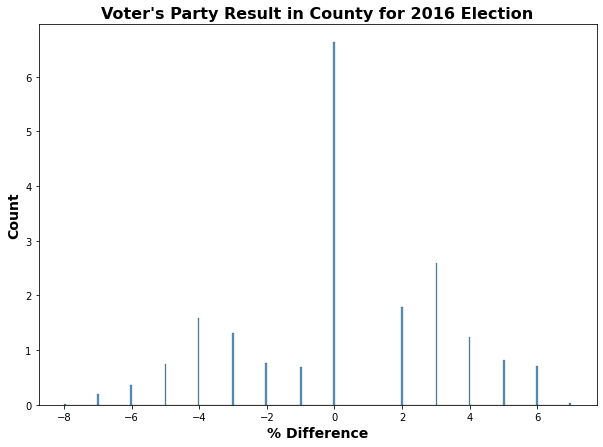

In [95]:
## Plot distribution of voter party results by county
plt.figure(figsize=(10,7))
ax = sns.histplot(elec_df['county_party_res_2016'], stat='density')
ax.set_title("Voter's Party Result in County for 2016 Election",
             fontsize=16, weight='bold')
ax.set_xlabel('% Difference', fontsize=14, weight='bold')
ax.set_ylabel('Count', fontsize=14, weight='bold');

In [96]:
check_unique('county_party_res_2016', elec_df)

,count,%
0.0,2500339,34.04
3.0,980160,13.34
2.0,671959,9.15
-4.0,595805,8.11
-3.0,492146,6.70
4.0,468271,6.37
5.0,312246,4.25
-2.0,289276,3.94
-5.0,280612,3.82
6.0,265095,3.61


## Load in Full Clean Dataset

In [93]:
# elec_df.to_csv('Data/NC_gen_2020_clean.gz', compression='gzip', index=False)

In [5]:
## Import and preview dataset
elec_df = pd.read_csv('Data/NC_gen_2020_clean.gz',
                     dtype={'precinct_abbrv': str, 
                            'super_court_abbrv': str, 
                            'judic_dist_abbrv': str,
                            'school_dist_abbrv': str,
                            'vtd_abbrv': str
                           })
elec_df.head()

,ncid,no_vote_his,birth_age_adj,voting_method,Gen_2020,party_cd,gender_code,birth_year,registr_dt,race_code,ethnic_code,zip_code,res_street_address,res_city_desc,state_cd,birth_state,drivers_lic,voted_county_id,precinct_abbrv,vtd_abbrv,cong_dist_abbrv,super_court_abbrv,judic_dist_abbrv,nc_senate_abbrv,nc_house_abbrv,school_dist_abbrv,county_id,diff,county_party_res_2016,county_party_res_2016_tri,Gen_2020_binary,party_grp,race_grp,birth_reg_cens,birth_reg_other
0,AA56273,0,85.0,ABSENTEE BY MAIL,Early,UNA,F,1935,1984-10-01,W,NL,27253.0,4430 E GREENSBORO-CHAPEL HILL RD,GRAHAM,NC,NY,0,1.0,08N,08N,13.0,15A,15A,24.0,64.0,NaN,1,12.551003,0.0,0.0,1,Other,W,Northeast,Northeast
1,AA201627,0,42.0,ABSENTEE ONESTOP,Early,UNA,F,1978,2018-02-23,W,UN,27302.0,117 W CLAY ST,MEBANE,NC,DC,1,1.0,10N,10N,13.0,15A,15A,24.0,63.0,NaN,1,12.551003,0.0,0.0,1,Other,W,South,South
2,AA216996,0,54.0,ABSENTEE ONESTOP,Early,REP,M,1966,2020-10-31,W,UN,27302.0,3670 COVINGTON TRL,MEBANE,NC,AL,0,1.0,103,103,13.0,15A,15A,24.0,63.0,NaN,1,12.551003,2.0,1.0,1,REP,W,South,South
3,AA98377,0,44.0,ABSENTEE ONESTOP,Early,UNA,F,1976,1996-03-26,W,UN,27215.0,421 WHITT AVE,BURLINGTON,NC,NC,1,1.0,03S,03S,13.0,15A,15A,24.0,64.0,NaN,1,12.551003,0.0,0.0,1,Other,W,South,South
4,AA69747,0,75.0,ABSENTEE ONESTOP,Early,UNA,F,1945,1989-08-15,W,NL,27215.0,1013 EDITH ST,BURLINGTON,NC,VA,1,1.0,124,124,13.0,15A,15A,24.0,63.0,NaN,1,12.551003,0.0,0.0,1,Other,W,South,South


## Relationship to Target (Gen_2020 voting method)

In [6]:
method_by_party = elec_df.groupby(['Gen_2020', 'party_grp']).size().to_frame().reset_index()
method_by_party.rename(columns={0: 'Count'}, inplace=True)
method_by_party

,Gen_2020,party_grp,Count
0,Early,DEM,1654622
1,Early,Other,1402389
2,Early,REP,1428133
3,Election Day,DEM,218234
4,Election Day,Other,290295
5,Election Day,REP,335189
6,No Vote,DEM,734705
7,No Vote,Other,799778
8,No Vote,REP,459318
9,Other,DEM,7739


In [113]:
def get_px_hist(df, group_col_1, group_col_2, title=None, barmode='group',
                template='seaborn'):
    
    cat_orders = {}
    labels = {}
    
    if group_col_2 == 'party_grp':
        color_map = {
            'Dem': 'blue',
            'Rep': 'red',
            'Other': 'gold'
        }
    if (group_col_1 == 'party_grp') | (group_col_2 == 'party_grp'):
        cat_orders.update({'party_grp': ['Dem', 'Rep', 'Other']})
        labels.update({'party_grp': 'Party'})
    
    
    if group_col_2 == 'Gen_2020':
        color_map = {
            'Early': 'navy',
            'No Vote': 'goldenrod',
            'Election Day': 'teal',
            'Other': 'aqua'
        }
    if (group_col_1 == 'Gen_2020') | (group_col_2 == 'Gen_2020'):
        cat_orders.update({'Gen_2020': ['Early', 'No Vote',
                                        'Election Day', 'Other']})
        labels.update({'Gen_2020': 'Voting Method'})
        
        
    if group_col_2 == 'race_grp':
        color_map = {
            'White': 'forestgreen',
            'Black': 'firebrick',
            'Undesig.': 'mediumslateblue',
            'Other': 'fuchsia'
        }
    if (group_col_1 == 'race_grp') | (group_col_2 == 'race_grp'):
        cat_orders.update({'race_grp': ['White',
                                        'Black',
                                        'Undesig.',
                                        'Other']})
        labels.update({'race_grp': 'Race'})
    
    
    if group_col_2 == 'gender_code':
        color_map = {
            'F': 'deeppink',
            'M': 'deepskyblue',
            'U': 'lawngreen'
        }
    if (group_col_1 == 'gender_code') | (group_col_2 == 'gender_code'):
        cat_orders.update({'gender_code': ['F', 'M', 'U']})
        labels.update({'gender_code': 'Gender'})
        
        
    if group_col_2 == 'birth_reg_other':
        color_map = {
            'South': '#AB63FA',
            'Missing': '#FFA15A',
            'Northeast': '#19D3F3',
            'Midwest': '#FF6692',
            'Other': '#B6E880',
            'West': '#FF97FF'
        }
    if (group_col_1 == 'birth_reg_other') | (group_col_2 == 'birth_reg_other'):
        cat_orders.update({'birth_reg_other': ['South',
                                               'Missing',
                                               'Northeast',
                                               'Midwest',
                                               'Other',
                                               'West']})
        labels.update({'birth_reg_other': 'Birth Region'})
    
    
    if group_col_2 == 'drivers_lic':
        color_map = {
            'Y': 'green',
            'N': 'crimson'
        }
    if (group_col_1 == 'drivers_lic') | (group_col_2 == 'drivers_lic'):
        cat_orders.update({'drivers_lic': ['Y', 'N']})
        labels.update({'drivers_lic': 'Drivers License'})
        
    
    fig = px.histogram(df, x=group_col_1, color=group_col_2,
                       color_discrete_map=color_map, barmode=barmode, 
                       title=title, 
                       category_orders=cat_orders,
                       labels=labels,
                       template=template
                      )
    
    return fig

In [114]:
def get_pie_count(df, group_col_1, group_col_2, col_1_cat, title=None,
                  template='seaborn'):
    
    labels={}
    
    if group_col_2 == 'party_grp':
        color_map = {
            'Dem': 'blue',
            'Rep': 'red',
            'Other': 'gold'
        }
        labels.update({'party_grp': 'Party'})
    
    if group_col_2 == 'Gen_2020':
        color_map = {
            'Early': 'navy',
            'No Vote': 'goldenrod',
            'Election Day': 'teal',
            'Other': 'aqua'
        }
        labels.update({'Gen_2020': 'Voting Method'})
        
    if group_col_2 == 'race_grp':
        color_map = {
            'White': 'forestgreen',
            'Black': 'firebrick',
            'Undesig.': 'mediumslateblue',
            'Other': 'fuchsia'
        }
        labels.update({'race_grp': 'Race'})
    
    if group_col_2 == 'gender_code':
        color_map = {
            'F': 'deeppink',
            'M': 'deepskyblue',
            'U': 'lawngreen'
        }
        labels.update({'gender_code': 'Gender'})
        
    if group_col_2 == 'birth_reg_other':
        color_map = {
            'South': '#AB63FA',
            'Missing': '#FFA15A',
            'Northeast': '#19D3F3',
            'Midwest': '#FF6692',
            'Other': '#B6E880',
            'West': '#FF97FF'
        }
        labels.update({'birth_reg_other': 'Birth Region'})
    
    
    if group_col_2 == 'drivers_lic':
        color_map = {
            'Y': 'green',
            'N': 'crimson'
        }
        labels.update({'drivers_lic': 'Drivers License'})
    
    
    grouped_df = df.groupby([group_col_1,
                             group_col_2]).size().to_frame().reset_index()
    grouped_df.rename(columns={0: 'Count'}, inplace=True)
    filtered_df = grouped_df.loc[grouped_df[group_col_1]==col_1_cat]
    
    fig = px.pie(filtered_df, values='Count', names=group_col_2,
                 title=title, color=group_col_2,
                 color_discrete_map=color_map,
                 template=template,
                 labels=labels)
    
    return fig

### By Age

In [ ]:
# fig = px.histogram(elec_df, x='birth_age_adj',
#                    color='Gen_2020', barmode='group', nbins=50)
# fig.show()

### By Party

In [63]:
# get_px_hist(elec_df, 'Gen_2020', 'party_grp', title='Voting Method by Party')

In [80]:
get_pie_count(elec_df, 'Gen_2020', 'party_grp', 'Early',
              title='Early Voters by Party')

In [81]:
get_pie_count(elec_df, 'Gen_2020', 'party_grp', 'Election Day',
              title='Election Day Voters by Party')

In [82]:
get_pie_count(elec_df, 'Gen_2020', 'party_grp', 'No Vote',
              title='Non-Voters by Party')

In [83]:
get_pie_count(elec_df, 'Gen_2020', 'party_grp', 'Other',
              title='Provisional/ Transfer Voters by Party')

In [84]:
get_pie_count(elec_df, 'party_grp', 'Gen_2020', 'DEM',
              title='Votes by Democratic Party')

In [85]:
get_pie_count(elec_df, 'party_grp', 'Gen_2020', 'REP',
              title='Votes by Republican Party')

In [86]:
get_pie_count(elec_df, 'party_grp', 'Gen_2020', 'Other',
              title='Votes by Other Voters')

### By Race

In [87]:
# get_px_hist(elec_df, 'Gen_2020', 'race_grp', title='Voting Method by Race')

In [88]:
get_pie_count(elec_df, 'Gen_2020', 'race_grp', 'Early',
              title='Early Voters by Race')

In [89]:
get_pie_count(elec_df, 'Gen_2020', 'race_grp', 'Election Day',
              title='Election Day Voters by Race')

In [90]:
get_pie_count(elec_df, 'Gen_2020', 'race_grp', 'No Vote',
              title='Non-Voters by Race')

In [91]:
get_pie_count(elec_df, 'Gen_2020', 'race_grp', 'Other',
              title='Provisional/ Transfer Voters by Race')

In [92]:
get_pie_count(elec_df, 'race_grp', 'Gen_2020', 'W',
              title='Votes by White Voters')

In [93]:
get_pie_count(elec_df, 'race_grp', 'Gen_2020', 'B',
              title='Votes by Black Voters')

In [94]:
get_pie_count(elec_df, 'race_grp', 'Gen_2020', 'U',
              title='Votes by Voters of Undesignated Race')

In [95]:
get_pie_count(elec_df, 'race_grp', 'Gen_2020', 'O',
              title='Votes by Voters of Other Racial Backgrounds')

### By Gender

In [96]:
# get_px_hist(elec_df, 'Gen_2020', 'gender_code', title='Voting Method by Gender')

In [97]:
get_pie_count(elec_df, 'Gen_2020', 'gender_code', 'Early',
              title='Early Voters by Gender')

In [98]:
get_pie_count(elec_df, 'Gen_2020', 'gender_code', 'Election Day',
              title='Election Day Voters by Gender')

In [99]:
get_pie_count(elec_df, 'Gen_2020', 'gender_code', 'No Vote',
              title='Non-Voters by Gender')

In [100]:
get_pie_count(elec_df, 'Gen_2020', 'gender_code', 'Other',
              title='Provisional/ Transfer Voters by Gender')

In [101]:
get_pie_count(elec_df, 'gender_code', 'Gen_2020', 'F',
              title='Votes by Women')

In [102]:
get_pie_count(elec_df, 'gender_code', 'Gen_2020', 'M',
              title='Votes by Men')

In [103]:
get_pie_count(elec_df, 'gender_code', 'Gen_2020', 'U',
              title='Votes by Voters of Undesignated Gender')

### By Birth Region

In [ ]:
get_px_hist(elec_df, 'Gen_2020', 'birth_reg_other', 
            title='Voting Method by Birth Region')

In [ ]:
get_pie_count(elec_df, 'Gen_2020', 'birth_reg_other', 'Early',
              title='Early Voters by Birth Region')

In [ ]:
get_pie_count(elec_df, 'Gen_2020', 'birth_reg_other', 'Election Day',
              title='Election Day Voters by Birth Region')

In [ ]:
get_pie_count(elec_df, 'Gen_2020', 'birth_reg_other', 'No Vote',
              title='Non-Voters by Birth Region')

In [ ]:
get_pie_count(elec_df, 'Gen_2020', 'birth_reg_other', 'Other',
              title='Provisional/ Transfer Voters by Birth Region')

In [ ]:
get_pie_count(elec_df, 'birth_reg_other', 'Gen_2020', 'South',
              title='Votes by Voters from the South')

In [ ]:
get_pie_count(elec_df, 'birth_reg_other', 'Gen_2020', 'Missing',
              title='Votes by Voters with Missing Birth Region')

In [ ]:
get_pie_count(elec_df, 'birth_reg_other', 'Gen_2020', 'Northeast',
              title='Votes by Voters from the Northeast')

In [ ]:
get_pie_count(elec_df, 'birth_reg_other', 'Gen_2020', 'Midwest',
              title='Votes by Voters from the Midwest')

In [ ]:
get_pie_count(elec_df, 'birth_reg_other', 'Gen_2020', 'Other',
              title='Votes by Voters Born in U.S. Territories or Outside the U.S.')

In [66]:
get_pie_count(elec_df, 'birth_reg_other', 'Gen_2020', 'West',
              title='Votes by Voters from the West')

### By Possessing a Drivers License

In [124]:
# get_px_hist(elec_df, 'Gen_2020', 'drivers_lic', 
#             title='Voting Method by Voters with and without Drivers Licenses')

In [116]:
get_pie_count(elec_df, 'Gen_2020', 'drivers_lic', 'Early',
              title='Early Voters by Possession of Drivers License')

In [117]:
get_pie_count(elec_df, 'Gen_2020', 'drivers_lic', 'Election Day',
              title='Election Day Voters by Possession of Drivers License')

In [118]:
get_pie_count(elec_df, 'Gen_2020', 'drivers_lic', 'No Vote',
              title='Non-Voters by Possession of Drivers License')

In [119]:
get_pie_count(elec_df, 'Gen_2020', 'drivers_lic', 'Other',
              title='Provisional/ Transfer Voters by Possession of Drivers License')

In [122]:
get_pie_count(elec_df, 'drivers_lic', 'Gen_2020', 1,
              title='Votes by People with Drivers Licenses')

In [123]:
get_pie_count(elec_df, 'drivers_lic', 'Gen_2020', 0,
              title='Votes by People without Drivers Licenses')

### By County

In [130]:
# get_px_hist(elec_df, 'county_id', 'Gen_2020', 
#             title='Voting Method by County')

In [128]:
# get_px_hist(elec_df.loc[elec_df['county_id']==60], 'county_id', 'Gen_2020', 
#             title='Voting Method by County')

### By 2016 Party Performance within County

In [ ]:
# get_px_hist(elec_df, 'Gen_2020', 'county_party_res_2016_tri', 
#             title='Voting Method by 2016 Party Performance within County')

# MODEL

# INTERPRET

# Conclusions/Recommendations